In [1]:
import umap.umap_ as umap
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns

/scratch/.amisery/penv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append("/home/amisery/SemesterProject")
from models.engine_nodecl import NodeClassificationEngine
from data.sfgd_datamodules import NodeCL_h5dataset
from data.plotting_utils import *
from models.model_utils import *

In [3]:
%load_ext autoreload
%autoreload 2

## Loading Dataset and model

In [4]:
ckpt_path_deep = "/home/amisery/SemesterProject/saved_logs/version_56/checkpoints/epoch=63-step=13120.ckpt"
ckpt_path_fweight = "/home/amisery/SemesterProject/tb_logs/my_model/version_2/checkpoints/epoch=47-step=9840.ckpt"
model = NodeClassificationEngine.load_from_checkpoint(ckpt_path_deep, map_location="cpu", strict=False)

/scratch/.amisery/penv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:173: Found keys that are in the model state dict but not in the checkpoint: ['loss_fn.ce.weight']
/scratch/.amisery/penv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['loss_fn.weight']


In [5]:
dataset_h5 = NodeCL_h5dataset("/scratch/.amisery/out_cap_1000.h5")

In [6]:
batch = get_batch_from_data(dataset_h5,0)

In [7]:
batch[1].shape

torch.Size([1, 238, 3])

In [8]:
l = 0
max_l = 100000
out_emb = torch.empty(0)
out_lab = torch.empty(0)
mis_cl = torch.empty(0)
while l < max_l :
    i = np.random.randint(len(dataset_h5))
    batch = get_batch_from_data(dataset_h5,i)
    model_pred = torch.argmax(model(batch[0],batch[2]), dim=2)+1
    out_emb = torch.cat((out_emb,model.model.encoder(model.model.lin_emb(batch[0]), batch[2]).squeeze(0)))
    g_truth = torch.argmax(batch[1], dim=2).squeeze(0) +1
    out_lab = torch.cat((out_lab, g_truth))
    mis_cl = torch.cat((mis_cl,(g_truth==model_pred).int().squeeze(0)))
    l += batch[0].shape[1]


In [9]:
umapT = umap.UMAP(n_neighbors=20, min_dist=0.2, metric='euclidean')
u_fit = umapT.fit_transform(out_emb.detach().numpy())
u_fit_x = u_fit[:,0]
u_fit_y = u_fit[:,1]

/scratch/.amisery/penv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


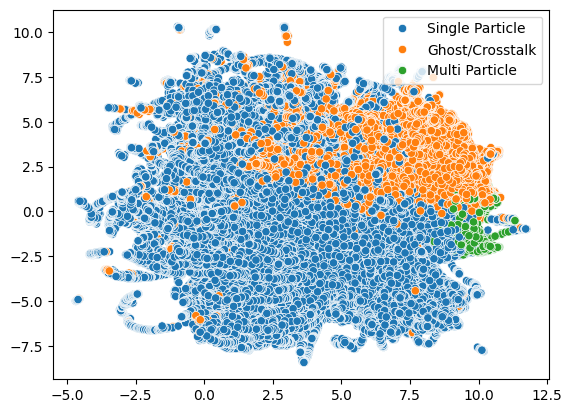

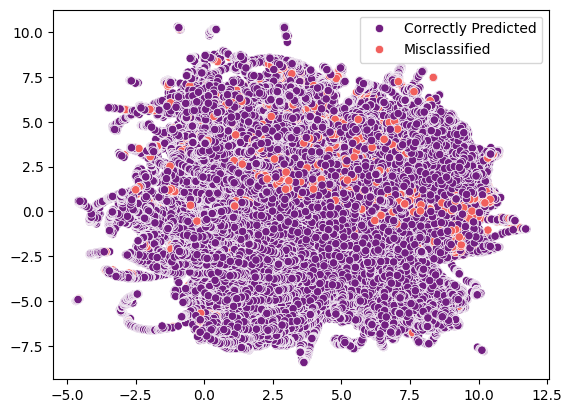

In [10]:
label_map = np.array(["Multi Particle", "Single Particle", "Ghost/Crosstalk"])
mis_cl_map = np.array(["Misclassified", "Correctly Predicted"])
sns.scatterplot(x = u_fit_x, y = u_fit_y, hue = label_map[out_lab.int()-1], palette = "tab10")
plt.legend()
plt.show()
plt.clf()
sns.scatterplot(x = u_fit_x, y = u_fit_y, hue = mis_cl_map[mis_cl.int()], palette = "magma")
plt.legend()
plt.show()